# Task 3: Implementación desde Cero
## Regresión Logística y K-Nearest Neighbours



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
sys.path.append('../task2')

warnings.filterwarnings('ignore', category=RuntimeWarning)

from data_loading import limpiar_datos
from feature_selection import seleccionar_features
from data_scaling import escalar_datos
from data_splitting import dividir_datos


## Cargar y Preparar Datos

In [3]:
# Cargar y preparar datos
df_clean = limpiar_datos('../task2/dataset_phishing.csv')
top_2_features, X_all, y = seleccionar_features(df_clean, n_features=2)

print(f" Features seleccionadas: {top_2_features}")
print(f" Dataset: {X_all.shape[0]} muestras, {X_all.shape[1]} features")

# Preparar dataset 2D para visualización
X_2d = df_clean[top_2_features]
X_2d_scaled, scaler_2d = escalar_datos(X_2d, y, method='standard')
X_train, X_test, y_train, y_test = dividir_datos(X_2d_scaled, y)

print(f" Training: {X_train.shape[0]} | Test: {X_test.shape[0]}")

 Features seleccionadas: ['google_index', 'page_rank']
 Dataset: 11430 muestras, 87 features
✅ Datos divididos: 9144 train (80%), 2286 test (20%)
 Training: 9144 | Test: 2286


---
# 1. Regresión Logística con Descenso del Gradiente

## 1. Hipótesis: Función Sigmoide

**Fórmula**: 
$$g(z) = \frac{1}{1 + e^{-z}}$$

**Predicción**:
$$\hat{y} = g(X \cdot w + b)$$

donde:
- $X$: matriz de features (n × 2)
- $w$: pesos (2 × 1)
- $b$: sesgo (escalar)

In [4]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))


def predict_proba(X, w, b):

    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return y_hat


## 2. Función de Costo: Log Loss (Binary Cross-Entropy)

**Fórmula**:
$$J(w,b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)})]$$

- Penaliza predicciones incorrectas
- Premia predicciones correctas

In [5]:
def compute_loss(y, y_hat):
    
    m = len(y)
    
    # Evitar log(0) agregando epsilon
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    
    # Binary Cross-Entropy
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    return loss

## 3. Gradient Descent (Entrenamiento)

**Gradientes**:

Para los pesos:
$$\frac{\partial J}{\partial w} = \frac{1}{m} X^T (\hat{y} - y)$$

Para el sesgo:
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum (\hat{y} - y)$$

**Actualización**:
$$w = w - \alpha \frac{\partial J}{\partial w}$$
$$b = b - \alpha \frac{\partial J}{\partial b}$$

In [6]:
def train_logistic_regression(X_train, y_train, learning_rate=0.01, epochs=1000, verbose=True):

    m, n = X_train.shape
    
    # Inicializar pesos y sesgo
    w = np.zeros(n)
    b = 0
    
    # Historial de pérdida
    loss_history = []
    
    # Gradient Descent
    for epoch in range(epochs):
        # Forward pass: calcular predicciones
        y_hat = predict_proba(X_train, w, b)
        
        # Calcular costo
        loss = compute_loss(y_train, y_hat)
        loss_history.append(loss)
        
        # Calcular gradientes
        error = y_hat - y_train
        dw = (1/m) * np.dot(X_train.T, error)
        db = (1/m) * np.sum(error)
        
        # Actualizar parámetros
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Mostrar progreso
        if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
            print(f"Época {epoch:4d} | Loss: {loss:.6f}")
    
    return w, b, loss_history


## Entrenar el Modelo de Regresión Logística

In [7]:
# Convertir a arrays numpy
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values


# Entrenar modelo
w, b, loss_history = train_logistic_regression(
    X_train_np, 
    y_train_np, 
    learning_rate=0.1, 
    epochs=1000,
    verbose=True
)

print(f"\n Entrenamiento completado")
print(f"Pesos finales: w = {w}")
print(f"Sesgo final: b = {b:.4f}")
print(f"Loss final: {loss_history[-1]:.6f}")

Época    0 | Loss: 0.693147
Época  100 | Loss: 0.345432


Época  200 | Loss: 0.333686
Época  300 | Loss: 0.332057
Época  400 | Loss: 0.331740
Época  500 | Loss: 0.331670
Época  600 | Loss: 0.331653
Época  700 | Loss: 0.331649
Época  800 | Loss: 0.331648
Época  900 | Loss: 0.331648
Época  999 | Loss: 0.331647

 Entrenamiento completado
Pesos finales: w = [ 1.79614006 -1.1520124 ]
Sesgo final: b = -0.0483
Loss final: 0.331647


## 4. Gráfica de Costo (Loss vs Época)

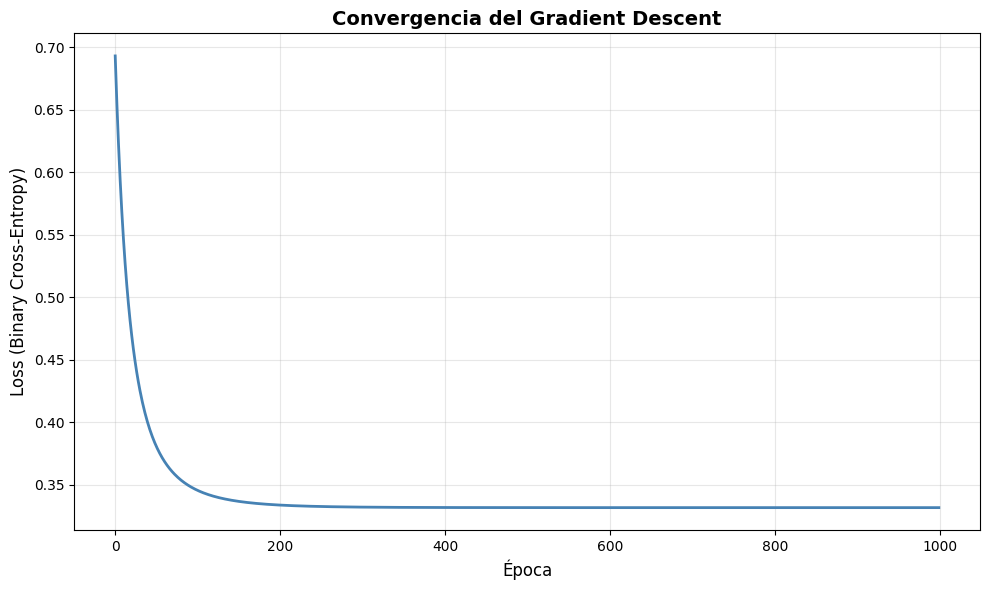

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, linewidth=2, color='steelblue')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
plt.title('Convergencia del Gradient Descent', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Evaluación en Test Set

In [9]:
def predict_class(X, w, b, threshold=0.5):

    y_proba = predict_proba(X, w, b)
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred


# Predecir en conjunto de prueba
y_pred_test = predict_class(X_test_np, w, b)

# Calcular accuracy
accuracy = np.mean(y_pred_test == y_test_np)

print(f"Accuracy en Test: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Matriz de confusión manual
tp = np.sum((y_pred_test == 1) & (y_test_np == 1))
tn = np.sum((y_pred_test == 0) & (y_test_np == 0))
fp = np.sum((y_pred_test == 1) & (y_test_np == 0))
fn = np.sum((y_pred_test == 0) & (y_test_np == 1))

print(f"\nMatriz de Confusión:")
print(f"  TP: {tp} | FP: {fp}")
print(f"  FN: {fn} | TN: {tn}")

Accuracy en Test: 0.8661 (86.61%)

Matriz de Confusión:
  TP: 980 | FP: 143
  FN: 163 | TN: 1000


## 6. Frontera de Decisión (Decision Boundary)

**Ecuación de la línea de decisión**:

Cuando $\hat{y} = 0.5$:
$$X \cdot w + b = 0$$
$$w_1 x_1 + w_2 x_2 + b = 0$$
$$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$$

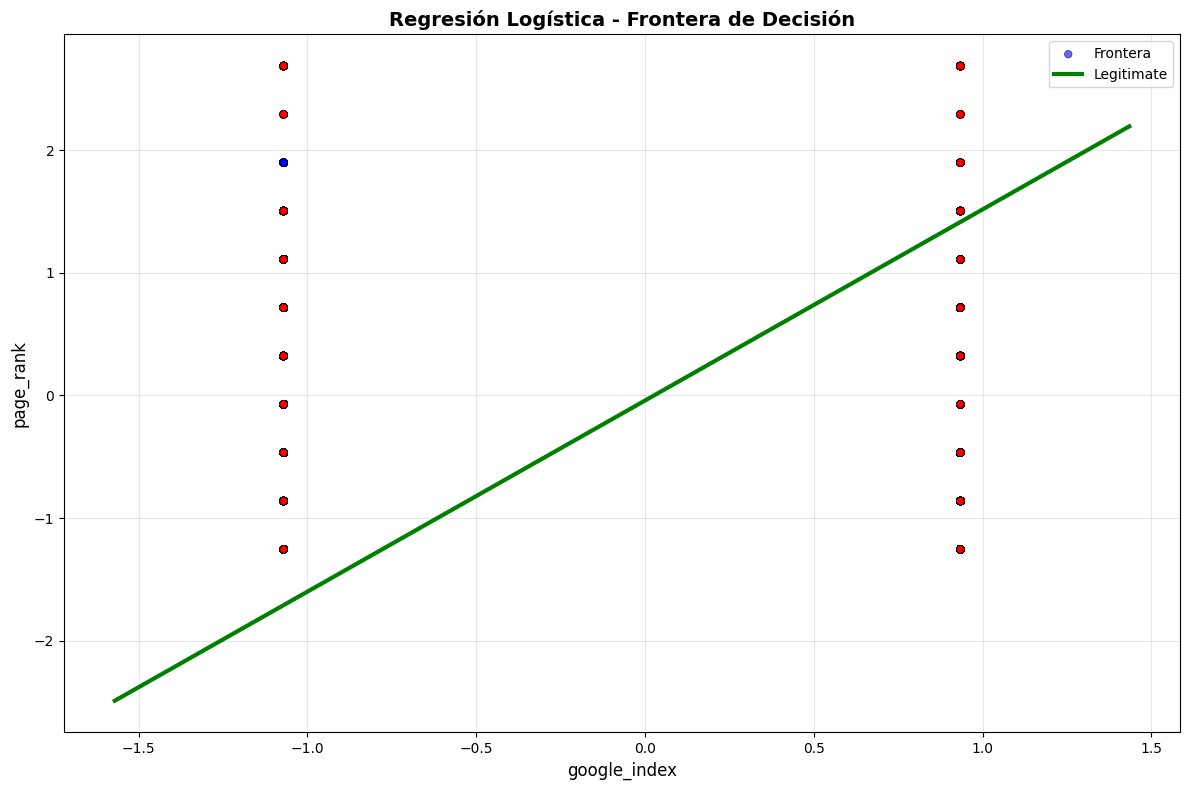

In [10]:
plt.figure(figsize=(12, 8))

# Scatter plot de puntos reales
colors = ['blue' if label == 0 else 'red' for label in y_train_np]
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=colors, alpha=0.6, 
            s=30, edgecolors='black', linewidth=0.5)

# Calcular línea de decisión: x2 = -(w1*x1 + b) / w2
x1_min, x1_max = X_train_np[:, 0].min() - 0.5, X_train_np[:, 0].max() + 0.5
x1_line = np.array([x1_min, x1_max])
x2_line = -(w[0] * x1_line + b) / w[1]

# Dibujar línea de decisión
plt.plot(x1_line, x2_line, 'g-', linewidth=3, label='Frontera de Decisión')

plt.xlabel(top_2_features[0], fontsize=12)
plt.ylabel(top_2_features[1], fontsize=12)
plt.title('Regresión Logística - Frontera de Decisión', fontsize=14, fontweight='bold')
plt.legend(['Frontera', 'Legitimate', 'Phishing'], loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()


---
# PARTE 2: K-Nearest Neighbours (KNN) Manual

## 1. Distancia Euclidiana

**Fórmula**:
$$d(x, x') = \sqrt{(x_1 - x'_1)^2 + (x_2 - x'_2)^2}$$

In [11]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


# Prueba
point1 = np.array([0, 0])
point2 = np.array([3, 4])
print(f"Distancia entre {point1} y {point2}: {euclidean_distance(point1, point2):.2f}")


Distancia entre [0 0] y [3 4]: 5.00


## 2. Función predict_knn

**Algoritmo**:
1. Para cada punto de prueba:
   - Calcular distancia a TODOS los puntos de entrenamiento
   - Ordenar por distancia
   - Tomar los k más cercanos
   - Votar por mayoría

In [12]:
def predict_knn(X_train, y_train, X_test, k=3):

    predictions = []
    
    # Para cada punto de prueba
    for test_point in X_test:
        # Calcular distancias a todos los puntos de entrenamiento
        distances = []
        for i, train_point in enumerate(X_train):
            dist = euclidean_distance(test_point, train_point)
            distances.append((dist, y_train[i]))
        
        # Ordenar por distancia
        distances.sort(key=lambda x: x[0])
        
        # Tomar los k más cercanos
        k_nearest = distances[:k]
        
        # Votar por mayoría
        k_labels = [label for _, label in k_nearest]
        prediction = 1 if sum(k_labels) > k/2 else 0
        
        predictions.append(prediction)
    
    return np.array(predictions)




## Evaluar KNN con k=3

In [13]:

# Predecir en conjunto de prueba
y_pred_knn = predict_knn(X_train_np, y_train_np, X_test_np, k=3)

# Calcular accuracy
accuracy_knn = np.mean(y_pred_knn == y_test_np)

print(f" Accuracy en Test: {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")

# Matriz de confusión
tp = np.sum((y_pred_knn == 1) & (y_test_np == 1))
tn = np.sum((y_pred_knn == 0) & (y_test_np == 0))
fp = np.sum((y_pred_knn == 1) & (y_test_np == 0))
fn = np.sum((y_pred_knn == 0) & (y_test_np == 1))

print(f"\nMatriz de Confusión:")
print(f"  TP: {tp} | FP: {fp}")
print(f"  FN: {fn} | TN: {tn}")

KeyboardInterrupt: 

## 3. Mapa de Decisión (Decision Boundary) con Malla

**Concepto**: Clasificar cada punto del plano para visualizar regiones de decisión.

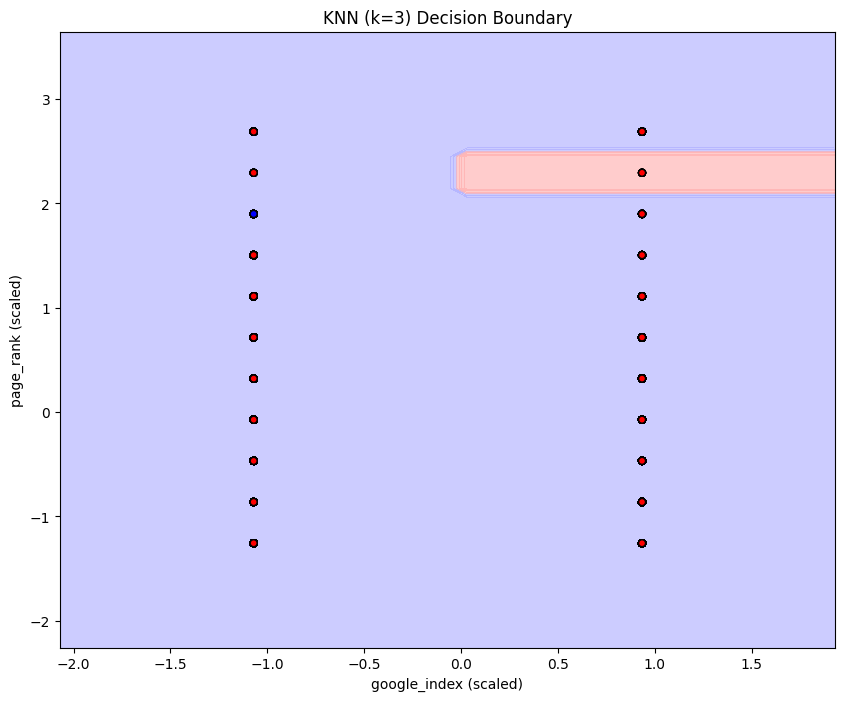

In [ ]:
from matplotlib.colors import ListedColormap

# Definir limites del grid
x_min = X_train_np[:, 0].min() - 1
x_max = X_train_np[:, 0].max() + 1
y_min = X_train_np[:, 1].min() - 1
y_max = X_train_np[:, 1].max() + 1

# Crear grid de puntos para visualizar
step = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

# Predecir clase para cada punto del grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict_knn(X_train_np, y_train_np, grid_points, k=3)
Z = Z.reshape(xx.shape)

# Colores para el mapa
colors_bg = ListedColormap(['#AAAAFF', '#FFAAAA'])
colors_points = ListedColormap(['#0000FF', '#FF0000'])

# Graficar
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=colors_bg, alpha=0.6)
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=y_train_np, 
            cmap=colors_points, edgecolor='k', s=25)

plt.xlabel(top_2_features[0] + ' (scaled)')
plt.ylabel(top_2_features[1] + ' (scaled)')
plt.title('KNN (k=3) Decision Boundary')
plt.savefig('knn_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()



---
## Comparación de Modelos

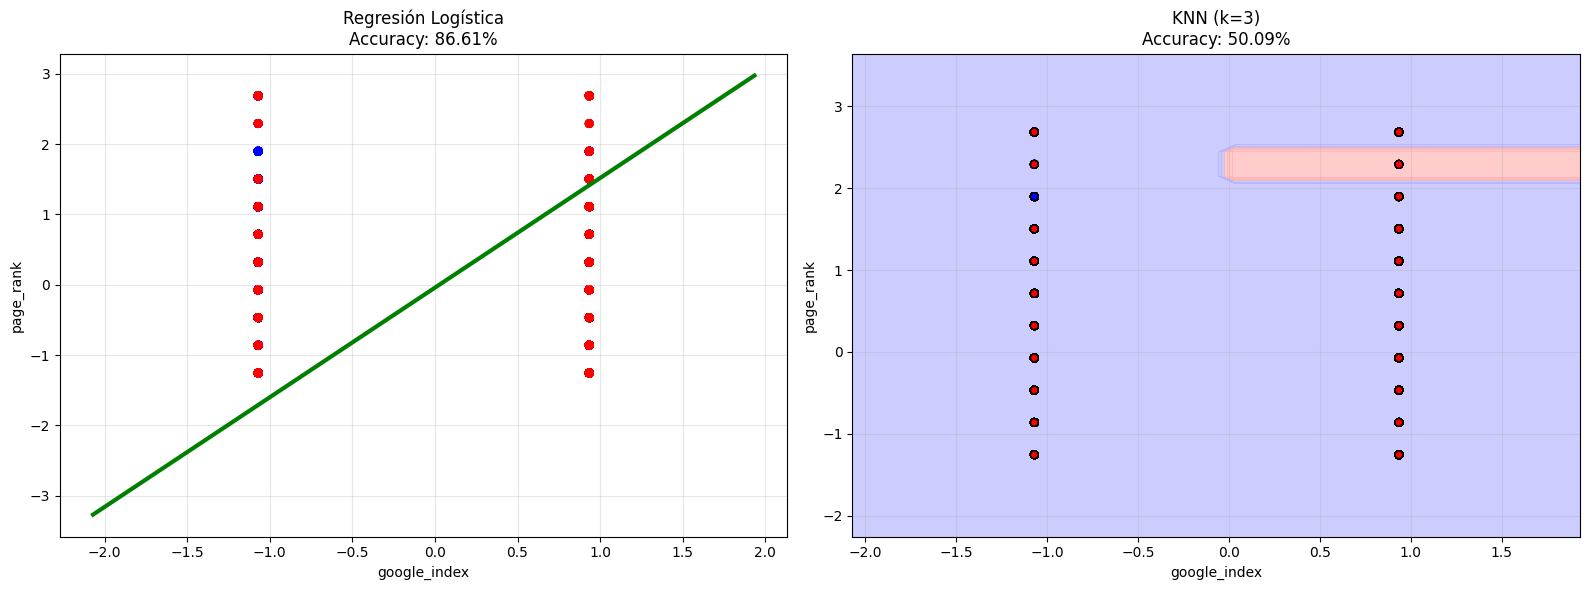

In [ ]:

# Visualización de comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regresión Logística
ax1 = axes[0]
colors = ['blue' if label == 0 else 'red' for label in y_train_np]
ax1.scatter(X_train_np[:, 0], X_train_np[:, 1], c=colors, alpha=0.6, s=30)
x_line = np.array([x_min, x_max])
y_line = -(w[0] * x_line + b) / w[1]
ax1.plot(x_line, y_line, 'g-', linewidth=3)
ax1.set_xlabel(top_2_features[0])
ax1.set_ylabel(top_2_features[1])
ax1.set_title(f'Regresión Logística\nAccuracy: {accuracy*100:.2f}%')
ax1.grid(True, alpha=0.3)

# KNN
ax2 = axes[1]
ax2.contourf(xx, yy, Z, alpha=0.6, cmap=colors_bg)
ax2.scatter(X_train_np[:, 0], X_train_np[:, 1], c=y_train_np, 
            cmap=colors_points, s=30, edgecolor='k')
ax2.set_xlabel(top_2_features[0])
ax2.set_ylabel(top_2_features[1])
ax2.set_title(f'KNN (k=3)\nAccuracy: {accuracy_knn*100:.2f}%')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
